# Spectral denoising as feature engineering

In this notebook we investigate the use of Fourier and Wavelet tranforms as a denosing pre-processing step prior to time series forecasting. This approach can be summarised as:
- step 1: Spectral tranforms of time series data, a transform from the time to frequency domain
- step 2: filter out high frequency noise components.
- step 3: inverses tranforms the frequency signal back to the time domain.
- step 4: forecasting the denoised signal. 

In [2]:
from one_dimensional_time_series_forecasting import time_series_prediction, hit_rate, invert_first_difference,invert_first_difference_2,invert_scaling, invert_first_difference_with_log_2
import pandas as pd

# model evalution metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error

# data preprocessing
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler

# interactive figures
%matplotlib widget 

# general data wrangling and visualization 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from tabulate import tabulate

# scientific computing for fourier transforms
from scipy.fft import fft, ifft, fftfreq

2022-05-12 17:09:32.923623: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-12 17:09:32.923640: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# 1. Fourier methods

In [ ]:
financial_assets = ['CrudeOil','S&P500','Apple','EurUsd'] # AirPassengers',
feat_engineering = 'fourier'
column_to_predict = 'Close' #'#Passengers' 

for financial_asset in financial_assets:
    ###################################################################################################
    # import some data
    ###################################################################################################

    df = pd.read_csv(f'./test_data/{financial_asset}_yfinance.csv') # sp_500 = GSPC.csv, # airplaine = AirPassengers.csv
    df = df.iloc[-2000:,:].reset_index(drop=True) # only look at last 2000 days
    # df['Date'] = df['Month']
    df.plot(x='Date',y=f'{column_to_predict}',figsize=(10,5),legend=True,xlabel='Month',subplots=True)
    plt.tight_layout()
    display(df)

    ###################################################################################################
    # feature engineering
    ###################################################################################################

    

    ###################################################################################################
    # single out of sample validation results
    ###################################################################################################

    # some forecasting parameters
    window_length = 10
    split = 500 # 44 for AirPlane

    # input data
    scaler = MinMaxScaler()
    scaled_training_data = scaler.fit_transform(df[f'{column_to_predict}'][0:-split].to_numpy().reshape(-1,1)).flatten()
    scaled_test_data = scaler.transform(df[f'{column_to_predict}'][-split:].to_numpy().reshape(-1,1)).flatten()
    scaled_input_data = np.append(scaled_training_data,scaled_test_data)

    # initialize class object
    blah = time_series_prediction(financial_asset,feat_engineering,df['Date'],scaled_input_data,window_length,1)#time_series_prediction(sp_500['Date'][-4000:],sp_500['Volume'][-4000:]/1e9,5,1) # pass: ime series dates, univariate time series, lag window length, a number of steps ahead to predict
    blah.sliding_window_1(verbose=0) # time series to supervised ML problem
    blah.train_test_split(split=split) # testing and training dataset split
    blah.test_train_plot(ylabel='Close price')    # visualize training split

    # perform some prediction tasks
    blah.linear_regression()
    blah.support_vector_machine(model_tunning=True,C= 0.1, kernel= 'linear',epsilon=0.1)
    blah.neural_net_mlp(model_tunning=True,
                        activation= 'relu', 
                        hidden_layer_sizes= (100, 100, 100), 
                        learning_rate= 'invscaling', 
                        learning_rate_init= 0.001,
                        solver='adam')
    blah.lstm(model_tunning=True,n_batch=64)
    blah.naive_model()

    # tabulate results nicely
    blah.collect_results()

    # visualize results
    blah.vis_results_time_series(ylabel='Close price',second_plot='error')

    # view final results
    blah.conclusion()


    ###################################################################################################
    # walk forward validation results
    ###################################################################################################
    mapping = {'LinearReg':blah.linear_regression_model,
                'svr':blah.svr_model,
                'MLP':blah.mlp_model,
                'LSTM':blah.lstm_model}

    # store evaulation results for different models
    model_results = []
    model_pred_results = {'Original Values':None,
                'LinearReg':None,
                'svr':None,
                'MLP':None,
                'LSTM':None,
                }

    # apply walkforward for all models
    for model_name in mapping.keys():

        # retrieve model
        model = mapping[model_name]

        # apply walk forward and save results
        train_len = 225 # 48 for Airplane
        test_len = 25   # 12 for Airplane
        df_walk_forward, df_hit_rate, mse,mae,mape,accuracy = blah.walk_forward_val(model_name,model,
                                                                                    train_len=train_len,
                                                                                    test_len=test_len,
                                                                                    train_frequency=10)
        # wrangle results
        
        # plots
        df_walk_forward['error'] = abs((df_walk_forward['real_value'] - df_walk_forward['prediction']))# / df_walk_forward['real_value'])
        
        fig, ax = plt.subplots(2,1, figsize=(10,8),sharex=True)
        ax[0].plot(df_walk_forward['date'],df_walk_forward['real_value'])
        ax[0].set_ylabel('Close')

        ax[1].plot(df_walk_forward['date'],df_walk_forward['error'],color='tab:orange')
        ax[1].set_title('Walk forward error through time')
        ax[1].set_xlabel('Dates')
        ax[1].legend()

        max = df_walk_forward.shape[0]
        ax[1].set_xticks([df_walk_forward['date'].iloc[x] for x in range(0,max,150)])
        ax[1].tick_params(rotation=30)
        ax[1].set_ylabel('Error')
        ax[1].set_xlabel('Date')
        plt.tight_layout()
        plt.savefig(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_{model_name}_wf.png',facecolor='w')
        plt.close()

        # tables 
        model_results.append({'model':model_name,'mse':mse,'mae':mae,'mape':mape,'accuracy':accuracy})

        # save prediction so we can view inverted walk forward results too
        model_pred_results['Original Values'] = df_walk_forward['real_value'].to_numpy()
        model_pred_results[model_name] = df_walk_forward['prediction'].to_numpy()
        
    # place wf results into df, save to csv and latex table
    df_conclusion_wf = pd.DataFrame.from_records(model_results)
    df_conclusion_wf.to_csv(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_results_summary_wf.csv')    
    
    latex_table = tabulate(df_conclusion_wf, headers='keys', tablefmt="latex_longtable")
    with open(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_latex_table_wf.txt',"w") as my_latex_table:
        my_latex_table.write(latex_table)

    # plot wf prediction results through time
    for model in model_pred_results.keys():
        model_pred_results[model] = model_pred_results[model].astype(float)

    model_pred_results['Date'] = df['Date'].iloc[train_len:]
    df_wf_results = pd.DataFrame.from_dict(model_pred_results)
    ax = df_wf_results.plot(figsize=(10,4), x='Date',fontsize=15)
    ax.set_ylabel(ylabel=f'{column_to_predict}',fontsize=15)
    ax.set_xlabel(xlabel='Date',fontsize=15)
    ax.tick_params(labelsize=12,rotation=30)

    plt.tight_layout()
    plt.savefig(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_wf_results.png')



,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-01-23,1842.290039,1842.290039,1820.060059,1828.459961,1828.459961,3972250000
1,2014-01-24,1826.959961,1826.959961,1790.290039,1790.290039,1790.290039,4618450000
2,2014-01-27,1791.030029,1795.979980,1772.880005,1781.560059,1781.560059,4045200000
3,2014-01-28,1783.000000,1793.869995,1779.489990,1792.500000,1792.500000,3437830000
4,2014-01-29,1790.150024,1790.150024,1770.449951,1774.199951,1774.199951,3964020000
...,...,...,...,...,...,...,...
1995,2021-12-23,4703.959961,4740.740234,4703.959961,4725.790039,4725.790039,2194630000
1996,2021-12-27,4733.990234,4791.490234,4733.990234,4791.189941,4791.189941,2264120000
1997,2021-12-28,4795.490234,4807.020020,4780.040039,4786.350098,4786.350098,2217050000
1998,2021-12-29,4788.640137,4804.060059,4778.080078,4793.060059,4793.060059,2369370000


Threshold found! Threshold: 2.676965625458425 Test: 96.03960396039604


/home/tristan/my_venvs/meng-data-science/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/tristan/my_venvs/meng-data-science/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/tristan/my_venvs/meng-data-science/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


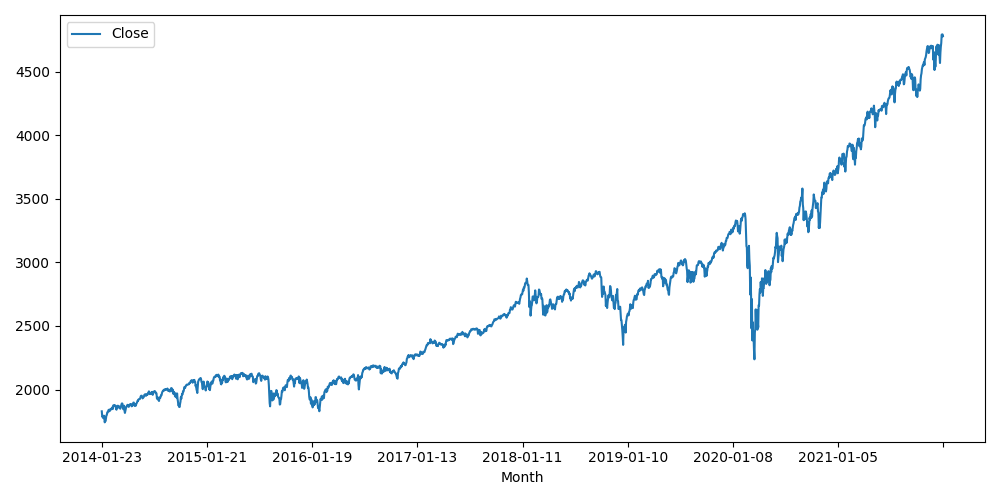

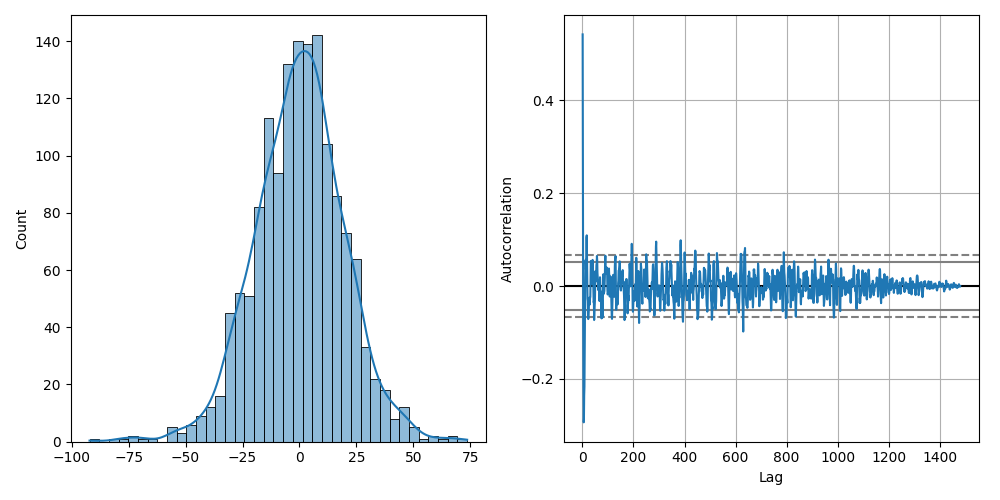

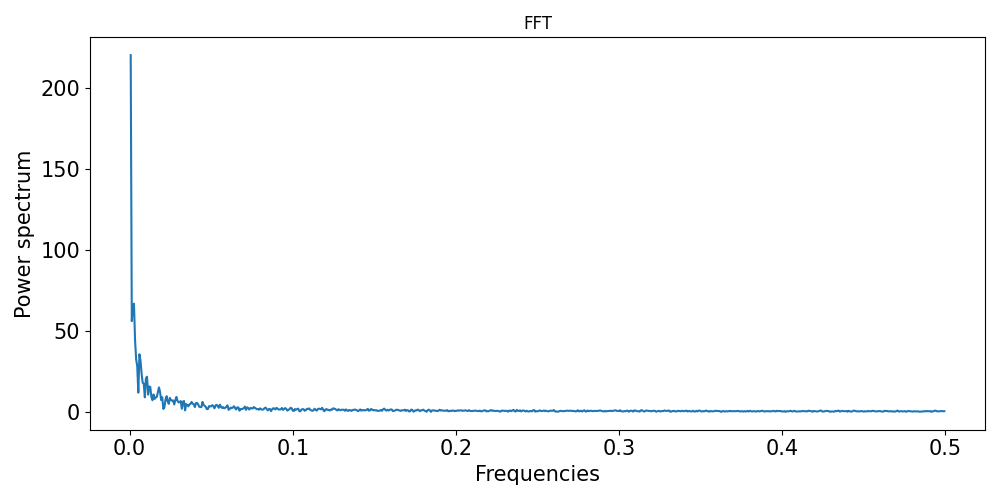

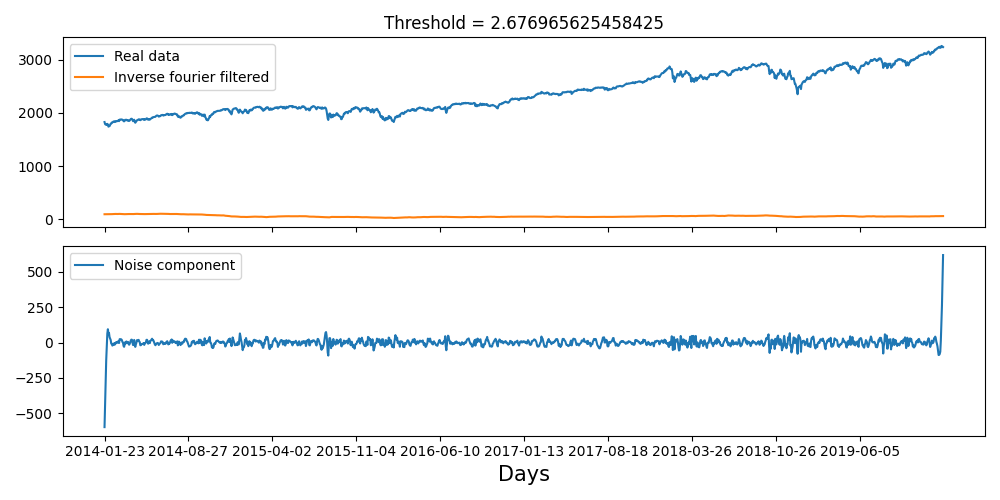

In [52]:
financial_asset =  'S&P500'#,'Apple','EurUsd' 'CrudeOil'
feat_engineering = 'fourier'
column_to_predict = 'Close' #'#Passengers' 
split = 500

###################################################################################################
# import some data
###################################################################################################

df = pd.read_csv(f'./test_data/{financial_asset}_yfinance.csv') # sp_500 = GSPC.csv, # airplaine = AirPassengers.csv
df = df.iloc[-2000:,:].reset_index(drop=True) # only look at last 2000 days
# df['Date'] = df['Month']
df.plot(x='Date',y=f'{column_to_predict}',figsize=(10,5),legend=True,xlabel='Month',subplots=True)
plt.tight_layout()
display(df)

###################################################################################################
# feature engineering
###################################################################################################

# fft the testing data
signal = np.array(df[f'{column_to_predict}'][-2000:-split]) # data
denoised_signal = automatic_fourier_denoising(signal)

### Algorthim to test for white noise

In [38]:
# using statsmodel to generate autocorrelation function
from statsmodels.tsa.stattools import acf


def test_for_white_noise(inverse_transform_noise):
    """
    This function is used to test whether the noise component removed from the signal is
    white noise or not. If it is white noise it returns True, otherwise False.

    The test used to determine white noise or not is from: https://otexts.com/fpp2/wn.html
    """

    # compute autocorrelations
    acf_values = acf(np.real(inverse_transform_noise),nlags=100)

    # compute boundary for acceptable for white noise
    critical_val = 2/np.sqrt(len(inverse_transform_noise))

    # seperate negative and positive values
    postive_values = acf_values[acf_values > 0]
    negative_values = acf_values[acf_values < 0]

    # how many negative and posititve values are contained in the critical region
    num_pos_in_crit = len(postive_values[postive_values < critical_val])
    num_neg_in_crit = len(negative_values[negative_values < critical_val])

    # total percentage of correlation in critical region
    precentage = (num_pos_in_crit+num_neg_in_crit)/len(acf_values) * 100

    complete = None
    if precentage >= 95:
        complete = True
    else:
        complete = False

    return complete, precentage
    
# test function
test_for_white_noise(inverse_transform_noise)

(True, 96.03960396039604)

### Algorithm to determine fourier thresholding

Threshold found! Threshold: 0.09516725704532791 Test: 96.03960396039604


/home/tristan/my_venvs/meng-data-science/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


0.09516725704532791

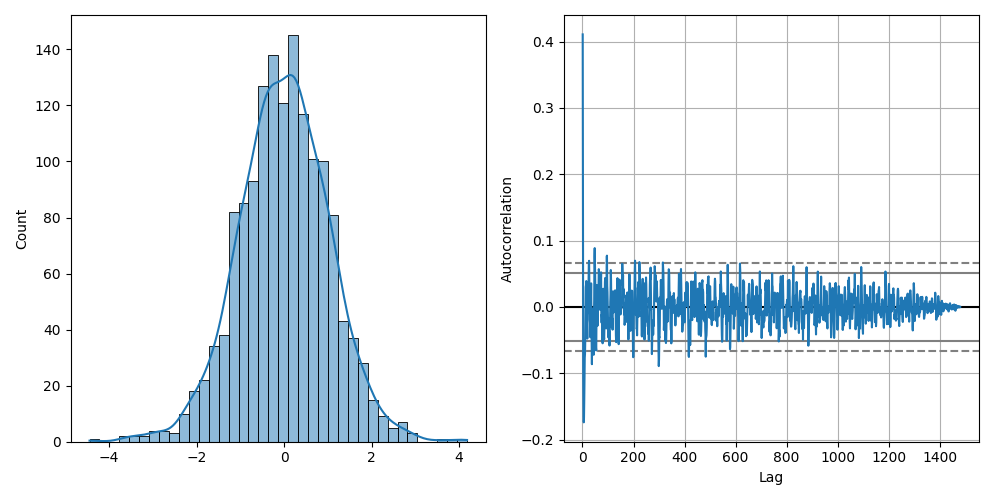

In [47]:
from pandas.plotting import autocorrelation_plot
import seaborn as sns

def find_threshold(signal):
    """
    This function is used to deterine what a good thresholding value is. It works by iterating
    through possible thresholding values until the noise component removed is found to be white
    noise.
    """

    # fft the uninvariete time series signal
    fft_coefficients = fft(signal) # fourier transform returns coefficients

    # plot amplitude vs frequency 
    n = len(signal)

    # get frequencies and psd
    freqs = fftfreq(signal.shape[0]) # x axis of amplitude vs frequency graphs
    psd = np.abs(fft_coefficients)/n # psd is amplitude/N, psd or power spectrum density is the magnitude of the coefficients resulting from fourier transform

    # retrieve highest amplitude coefficient
    threshold = np.max(psd[1:]) / 10 # initial guess for threshold

    # initial guess results
    psd_indices = psd  < threshold # mask the psd signal
    fft_filtered_noise = fft_coefficients*psd_indices
    inverse_transform_noise = ifft(fft_filtered_noise)

    # test if this component is white noise
    white_noise_1_0,percentage = test_for_white_noise(inverse_transform_noise)

    if white_noise_1_0 == True:
            print(f'Threshold found! Threshold: {threshold} Test: {percentage}') 

    # while thresholding has not removed a purely white noise component
    while white_noise_1_0 != True:
        threshold = threshold*.9 
        # noise component we are removing
        psd_indices = psd  < threshold # mask the psd signal
        fft_filtered_noise = fft_coefficients*psd_indices
        inverse_transform_noise = ifft(fft_filtered_noise)

        # is this removed component white noise?
        white_noise_1_0, percentage = test_for_white_noise(inverse_transform_noise)

        if white_noise_1_0 == True:
            print(f'Threshold found! Threshold: {threshold} Test: {percentage}')

    # some white noise evidence
    fig,ax = plt.subplots(1,2,figsize=(10,5))
    sns.histplot(np.real(inverse_transform_noise[10:-10]),kde=True,ax=ax[0])
    autocorrelation_plot(inverse_transform_noise[10:-10],ax=ax[1])
    plt.tight_layout()

    return threshold

# test function
find_threshold(signal)

Threshold found! Threshold: 0.09516725704532791 Test: 96.03960396039604


/home/tristan/my_venvs/meng-data-science/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/tristan/my_venvs/meng-data-science/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/tristan/my_venvs/meng-data-science/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


array([89094.56003189   +0.j        , 11571.60467013+1990.97648803j,
        3593.58836889-7936.63031718j, ...,  1239.41969523+8064.7962606j ,
        3593.58836889+7936.63031718j, 11571.60467013-1990.97648803j])

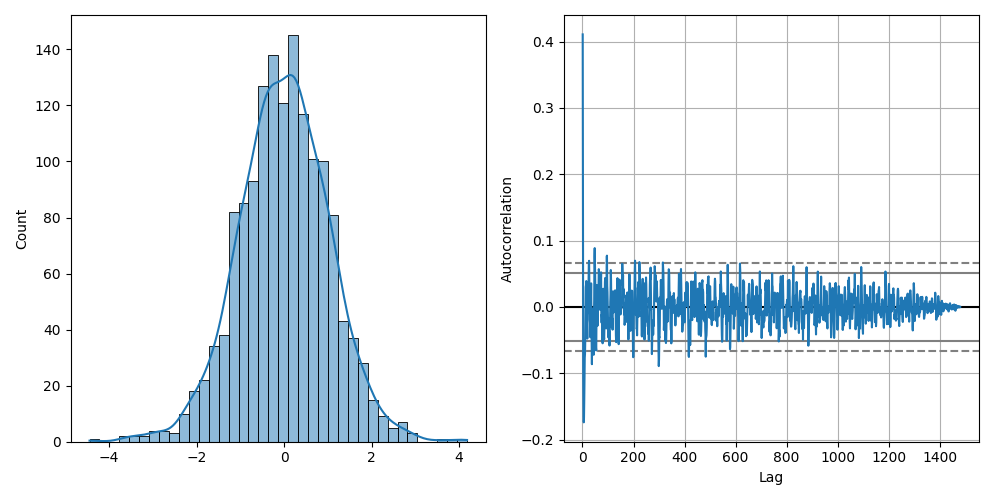

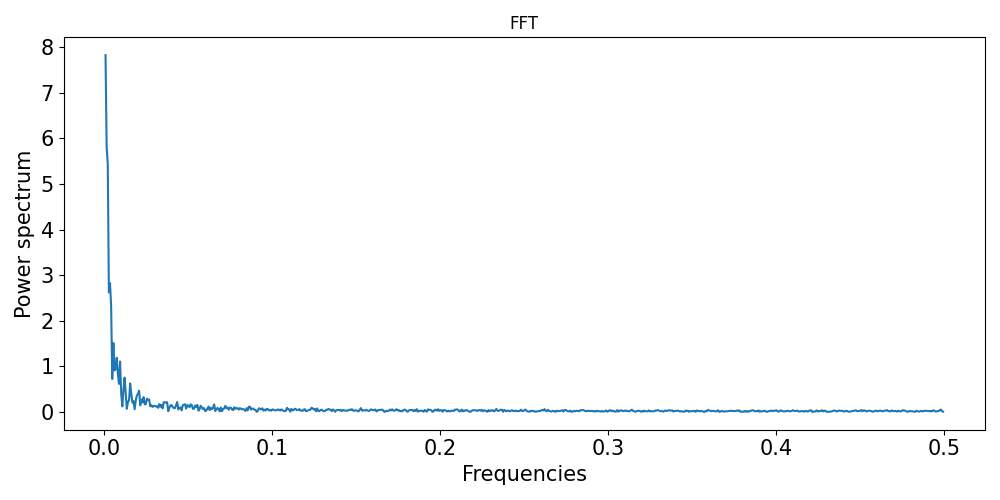

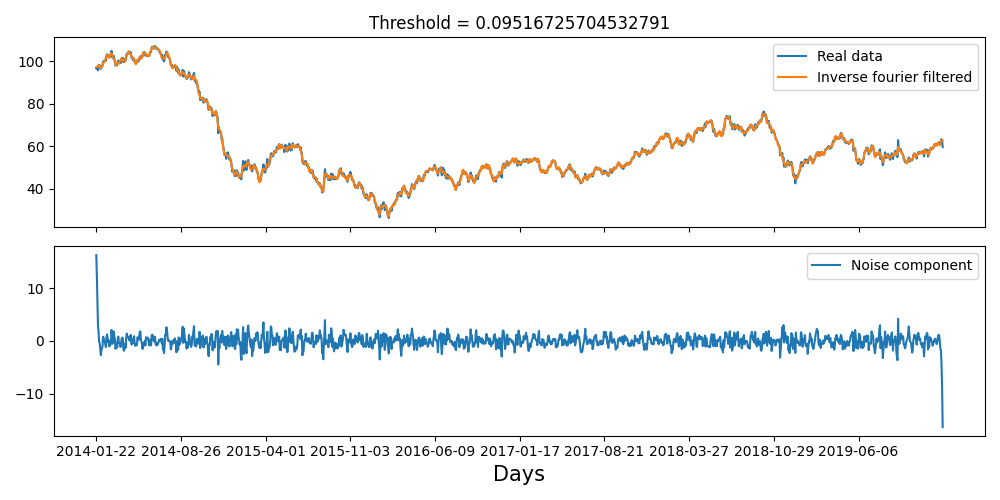

In [50]:
def automatic_fourier_denoising(signal):

    """
    This function implement automatic fourier denoising on a time series signal.
    """

    # step 1: Apply FFT and find threshold
    white_noise_threshold = find_threshold(signal)

    # step 2: Apply FFT and produce PSD
    fft_coefficients = fft(signal)
    n = len(signal)
    freqs = fftfreq(signal.shape[0]) # x axis of amplitude vs frequency graphs
    psd = np.abs(fft_coefficients)/n # psd is amplitude/N, psd or power spectrum density is the magnitude of the coefficients resulting from fourier transform

    # step 3: Denoise time series signal with this threshold, also retrieve noise component
    psd_indices = psd >  white_noise_threshold # mask the psd signal
    fft_filtered_denoised = fft_coefficients*psd_indices
    inverse_transform_filtered = ifft(fft_filtered_denoised)

    # white noise component
    psd_indices = psd  < white_noise_threshold 
    fft_filtered_noise = fft_coefficients*psd_indices
    inverse_transform_noise = ifft(fft_filtered_noise)

    # step 4: plot psd
    fig,ax = plt.subplots(figsize=(10,5))
    ax.plot(freqs[1:int(n/2)],psd[1:int(n/2)])
    ax.set_ylabel('Power spectrum',fontsize=15)
    ax.set_xlabel('Frequencies',fontsize=15)
    ax.set_title('FFT')
    ax.tick_params(labelsize=15)
    plt.tight_layout()

    # step 4: denoising results
    fig,ax = plt.subplots(2,1,figsize=(10,5),sharex=True)
    ax[0].plot(df['Date'][-2000:-split],signal,'-',label='Real data')
    ax[0].plot(df['Date'][-2000:-split],inverse_transform_filtered,'-',label='Inverse fourier filtered')
    ax[1].plot(df['Date'][-2000:-split],inverse_transform_noise,'-',label='Noise component')
    ax[0].legend()
    ax[1].legend()
    ax[0].set_title(f'Threshold = {white_noise_threshold}')
    ax[1].set_xlabel('Days',fontsize=15)
    ax[1].set_xticks([df['Date'][-2000:].iloc[x] for x in range(0,len(df['Date'][-2000:-split]),150)])
    plt.tight_layout()

    # return denoised signal
    return inverse_transform_filtered
    
# test function
automatic_fourier_denoising(signal)

In [ ]:
# plot amplitude vs frequency 
n = len(signal)

# get frequencies and psd
freqs = fftfreq(signal.shape[0]) # x axis of amplitude vs frequency graphs
psd = np.abs(fft_coefficients)/n # psd is amplitude/N, psd or power spectrum density is the magnitude of the coefficients resulting from fourier transform

# plot psd
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(freqs[1:int(n/2)],psd[1:int(n/2)])
ax.set_ylabel('Power spectrum',fontsize=15)
ax.set_xlabel('Frequencies',fontsize=15)
ax.set_title('FFT')
ax.tick_params(labelsize=15)
plt.tight_layout()

/home/tristan/my_venvs/meng-data-science/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


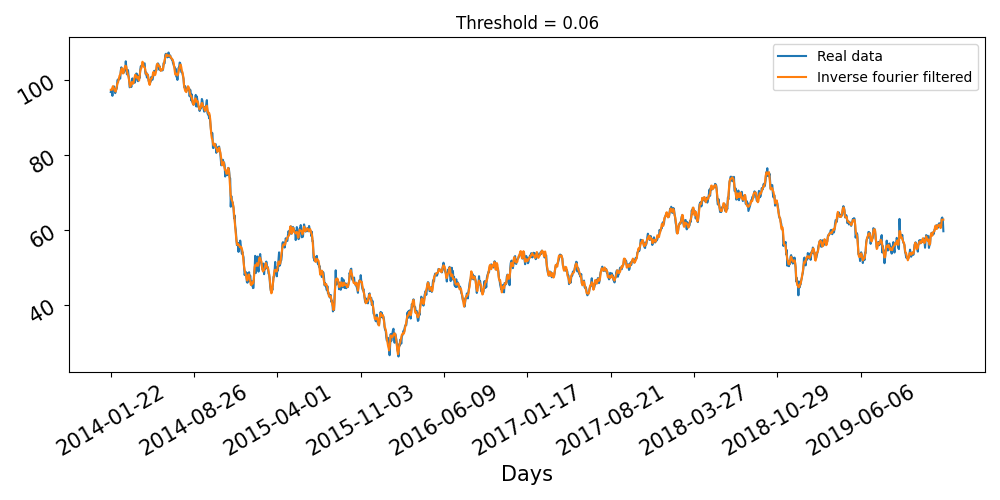

In [28]:
inverse_transform_filtered[0:3] = signal[1]
inverse_transform_filtered[-4:] = signal[-2]

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(df['Date'][-2000:-split],signal,'-',label='Real data')
ax.plot(df['Date'][-2000:-split],inverse_transform_filtered,'-',label='Inverse fourier filtered')
ax.legend()
ax.set_title('Threshold = 0.06')
ax.set_xlabel('Days',fontsize=15)
ax.set_xticks([df['Date'][-2000:-split].iloc[x] for x in range(0,len(df['Date'][-2000:-split]),150)])
ax.tick_params(rotation=30,labelsize=15)

plt.tight_layout()